In [1]:
#pip install linearmodels

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import contextily as ctx
from geopy.distance import geodesic
from esda.moran import Moran
from libpysal.weights import Queen, KNN, lag_spatial, lat2W
from splot.esda import moran_scatterplot, plot_moran
import contextily as ctx
import matplotlib.ticker as mticker
from matplotlib.colors import Normalize


from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


from shapely.geometry import Point
from pysal.model import spreg
from linearmodels.panel import PanelOLS, RandomEffects

import statsmodels.api as sm
from scipy.stats import chi2, t

import spreg
import libpysal as ps

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from shapely.geometry import Point
import warnings

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [3]:
warnings.filterwarnings("ignore")

In [4]:
from libpysal.weights import W, full2W
import seaborn as sns
from scipy import stats

# 1.Data Processing

In [5]:
data = pd.read_csv('data.csv')
# Replace '..' with NaN
data.replace('..', np.nan, inplace=True)

In [6]:
# Drop rows with any NaN values
data.dropna(inplace=True)

data['gdp_log'] = np.log(data['gdp'])

# Display the first few rows of the cleaned data
data.head(30)


,country,ISO3,year,broadband,telephone,cellular,internet,credit,education,ict,...,articles,business,fdi_outflow,fdi_inflow,gdp,gdp_growth,Innovation_index,latitude,longitude,gdp_log
0,Austria,AUT,2009,1878524,3253000,11434000,73.45,97.73957467,67.99157715,4.012334698,...,10837.18,1.098368169,3.872516754,3.559366135,3.560000e+11,-3.764578,0.078103,48.210033,16.363449,26.598197
1,Austria,AUT,2010,2050400,3398000,12241000,75.17,98.52832394,75.04025269,3.94819967,...,11058.41,1.068585825,-3.652443041,-5.610176315,3.620000e+11,1.837094,0.070135,48.210033,16.363449,26.614910
2,Austria,AUT,2011,2097700,3388000,13022578,78.7399931,96.06109929,77.26251221,3.7939034,...,11683.33,0.961632824,8.836365763,5.324236737,3.730000e+11,2.922797,0.061866,48.210033,16.363449,26.644844
3,Austria,AUT,2012,2130200,3380000,13588000,80.02999392,94.22379903,79.54712677,3.889467798,...,12050.36,0.99565769,4.505182228,1.274693933,3.760000e+11,0.680446,0.061673,48.210033,16.363449,26.652855
4,Austria,AUT,2013,2232500,3334000,13272000,80.6188,92.55775212,80.96160126,4.206127886,...,12201.98,1.046682823,2.56421002,0.104862186,3.760000e+11,0.025505,0.063309,48.210033,16.363449,26.652855
5,Austria,AUT,2014,2359000,3518900,12952605,80.99582496,87.55558785,81.0195694,4.277068444,...,12408.16,1.232728677,-0.197784974,0.386858115,3.780000e+11,0.661273,0.066570,48.210033,16.363449,26.658160
6,Austria,AUT,2015,2455500,3609900,13470623,83.94014193,85.89120788,82.25630951,4.116075846,...,12840.55,1.084121534,-0.560119576,-2.088056539,3.820000e+11,1.014502,0.063696,48.210033,16.363449,26.668686
7,Austria,AUT,2016,2523300,3567200,11079460,84.32374257,83.13573566,82.8496933,3.791092514,...,12668.55,1.012047577,-6.799712539,-7.310916958,3.900000e+11,1.989437,0.058205,48.210033,16.363449,26.689413
8,Austria,AUT,2017,2511400,3711200,10859000,87.93558659,84.26289373,83.83925629,3.483219307,...,12756.54,1.024764549,2.422529343,3.23990498,3.980000e+11,2.258572,0.058325,48.210033,16.363449,26.709718
9,Austria,AUT,2018,2521200,3735346,10984000,87.47913723,84.41367028,85.86988831,3.4121475,...,12713.75,0.994755862,-5.915302474,-6.287101585,4.080000e+11,2.425385,0.054852,48.210033,16.363449,26.734533


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 0 to 427
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              305 non-null    object 
 1   ISO3                 305 non-null    object 
 2   year                 305 non-null    int64  
 3   broadband            305 non-null    object 
 4   telephone            305 non-null    object 
 5   cellular             305 non-null    object 
 6   internet             305 non-null    object 
 7   credit               305 non-null    object 
 8   education            305 non-null    object 
 9   ict                  305 non-null    object 
 10  tech                 305 non-null    object 
 11  patent_residents     305 non-null    object 
 12  patent_nonresidents  305 non-null    object 
 13  researchers          305 non-null    object 
 14  RD                   305 non-null    object 
 15  gdppc                305 non-null    float64


In [8]:
# Check the columns and data types
print("Data types before conversion:\n", data.dtypes)

# Convert object type columns to numeric (if possible)
for col in data.select_dtypes(include=['object']).columns:
    if col not in ['country', 'ISO3']:
        try:
            data[col] = pd.to_numeric(data[col])
        except ValueError:
            print(f"Column {col} could not be converted to numeric and will be dropped.")
            data = data.drop(columns=[col])

# Drop columns that are still of object type (if necessary)
#data = data.select_dtypes(exclude=['object'])

# Check the columns and data types after conversion
print("Data types after conversion:\n", data.dtypes)

Data types before conversion:
 country                 object
ISO3                    object
year                     int64
broadband               object
telephone               object
cellular                object
internet                object
credit                  object
education               object
ict                     object
tech                    object
patent_residents        object
patent_nonresidents     object
researchers             object
RD                      object
gdppc                  float64
urban                  float64
articles                object
business                object
fdi_outflow             object
fdi_inflow              object
gdp                    float64
gdp_growth             float64
Innovation_index       float64
latitude               float64
longitude              float64
gdp_log                float64
dtype: object
Data types after conversion:
 country                 object
ISO3                    object
year                     i

In [9]:
data['patent'] = data['patent_residents'] + data['patent_nonresidents']

print(data)

         country ISO3  year  broadband  telephone    cellular   internet  \
0        Austria  AUT  2009    1878524    3253000  11434000.0  73.450000   
1        Austria  AUT  2010    2050400    3398000  12241000.0  75.170000   
2        Austria  AUT  2011    2097700    3388000  13022578.0  78.739993   
3        Austria  AUT  2012    2130200    3380000  13588000.0  80.029994   
4        Austria  AUT  2013    2232500    3334000  13272000.0  80.618800   
..           ...  ...   ...        ...        ...         ...        ...   
423  Switzerland  CHE  2012    3212371    4721981  10561075.0  85.200000   
424  Switzerland  CHE  2013    3438094    4593321  11048637.0  86.340000   
425  Switzerland  CHE  2014    3535986    4374700  11150000.0  87.400000   
426  Switzerland  CHE  2015    3700563    4140000  11243210.0  87.479056   
427  Switzerland  CHE  2016    3775916    3772545  11242105.0  89.134688   

         credit  education       ict  ...  business  fdi_outflow  fdi_inflow  \
0     9

# 2.Digital Economy Level

In [10]:
# Columns to be scaled
columns_to_scale = ['broadband', 'telephone', 'internet', 'cellular', 'credit', 'ict', 'tech']

In [11]:
''
#Standardize the data

scaler = MinMaxScaler()

data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])


In [12]:
# Calculate entropy
def calculate_entropy(data):
    P = data / data.sum(axis=0)  # Calculate the probability distribution
    E = -np.nansum(P * np.log(P), axis=0) / np.log(len(data))  # entropy
    return E

# Calculate weights
def calculate_weights(entropy):
    d = 1 - entropy  # Calculate the degree of diversification
    w = d / d.sum()  # Calculate weights
    return w

# Calculate the entropy for each indicator
entropy = calculate_entropy(data[columns_to_scale])

# Calculate the weights for each indicator
weights = calculate_weights(entropy)


print("Entropy:\n", entropy)
print("Weights:\n", weights)


Entropy:
 [0.86255415 0.82530532 0.99030845 0.87702014 0.95796231 0.9199691
 0.95123936]
Weights:
 [0.22325643 0.28376056 0.01574221 0.19975899 0.06828277 0.12999602
 0.07920302]


In [13]:
# Compute the comprehensive DE score
data['DE_index'] = data[columns_to_scale].dot(weights)

print(data.head())


   country ISO3  year  broadband  telephone  cellular  internet    credit  \
0  Austria  AUT  2009   0.048886   0.062718  0.100770  0.595704  0.317835   
1  Austria  AUT  2010   0.053647   0.065709  0.108155  0.623508  0.321264   
2  Austria  AUT  2011   0.054957   0.065502  0.115307  0.681220  0.310539   
3  Austria  AUT  2012   0.055857   0.065338  0.120481  0.702073  0.302552   
4  Austria  AUT  2013   0.058691   0.064389  0.117589  0.711592  0.295310   

   education       ict  ...  fdi_outflow  fdi_inflow           gdp  \
0  67.991577  0.077526  ...     3.872517    3.559366  3.560000e+11   
1  75.040253  0.075981  ...    -3.652443   -5.610176  3.620000e+11   
2  77.262512  0.072265  ...     8.836366    5.324237  3.730000e+11   
3  79.547127  0.074567  ...     4.505182    1.274694  3.760000e+11   
4  80.961601  0.082194  ...     2.564210    0.104862  3.760000e+11   

   gdp_growth  Innovation_index   latitude  longitude    gdp_log  patent  \
0   -3.764578          0.078103  48.2100

In [14]:
# Save the results to a CSV file
#data.to_csv('DE_Level.csv', index=False)

# 3.Innovation Level

The innvation_index is the innvation efficiency calculated by an open source software for Data envelopment analysis based Slacks-Based Measure (SBM) of Efficiency.

#### Descriptive Statistics

In [15]:
summary_selected_columns = data[['DE_index', 'Innovation_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log']].describe()
# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Increase display width
pd.set_option('display.colheader_justify', 'right')  # Right-align column headers
pd.set_option('display.precision', 2)  # Set the number of decimal places

# Format the result to match the data table style
formatted_summary = summary_selected_columns.applymap(lambda x: f'{x:.2f}')
print(formatted_summary)


      DE_index Innovation_index   urban fdi_inflow fdi_outflow gdp_growth gdp_log
count   305.00           305.00  305.00     305.00      305.00     305.00  305.00
mean      0.16             0.15   73.05       9.86        7.14       1.22   25.92
std       0.15             0.23   12.57      37.30       43.33       3.58    1.49
min       0.03             0.00   52.43    -117.37     -137.32     -14.63   22.81
25%       0.08             0.03   64.65       0.80        0.24       0.23   24.63
50%       0.11             0.06   72.64       2.42        1.36       1.87   26.04
75%       0.16             0.12   81.48       4.54        3.35       3.16   26.84
max       0.72             1.02   98.08     279.36      300.42      10.87   28.91


# 4.Geographically Weighted Regression

In [16]:
print(data.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index'], dtype='object')


In [17]:
# Dynamically patch numpy deprecations in spglm
import spglm
import sys

if 'spglm.iwls' in sys.modules:
    del sys.modules['spglm.iwls']
    
import spglm.iwls

spglm.iwls.np.float = np.float64

In [18]:
# Ensure all required columns are present
required_columns = ['ISO3', 'latitude', 'longitude', 'DE_index', 'Innovation_index', 'gdppc', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_log', 'gdp_growth']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"{missing_columns} not in index")

Text(0.5, 1.0, 'Correlation Matrix')

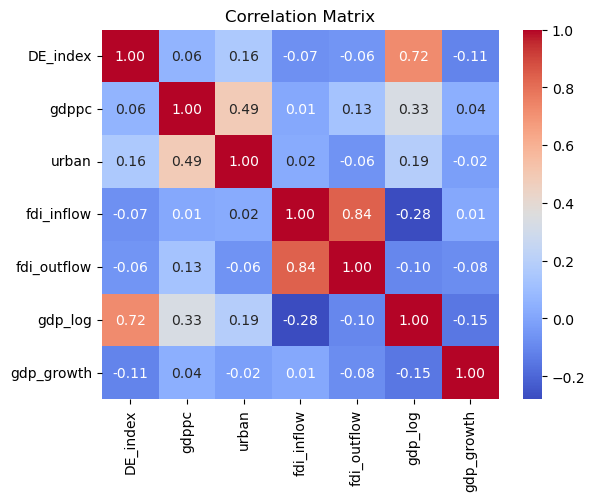

In [19]:
# Select only the columns of interest for the correlation matrix
cols_of_interest = ['DE_index', 'gdppc', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_log', 'gdp_growth']
sci_selected = data[cols_of_interest]


sns.heatmap(sci_selected.corr(numeric_only=True), # plot a correlation matrix 
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [20]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(data.copy(), geometry=gpd.points_from_xy(data.longitude, data.latitude))

In [21]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index', 'geometry'], dtype='object')


In [22]:
# Clean data: Remove rows with inf or NaN values
gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
gdf.dropna(subset=['DE_index', 'urban', 'gdppc', 'fdi_inflow', 'fdi_outflow', 'gdp', 'gdp_growth'], inplace=True)

In [23]:
# Calculate VIF for each explanatory variable
X = add_constant(gdf[['DE_index', 'gdppc', 'urban', 'fdi_inflow', 'fdi_outflow'	, 'gdp', 'gdp_growth']])
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

       feature    VIF
0        const  43.18
1     DE_index  23.76
2        gdppc   1.88
3        urban   1.51
4   fdi_inflow   4.26
5  fdi_outflow   4.18
6          gdp  24.54
7   gdp_growth   1.06


In [24]:
def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')
        
        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
            
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [25]:
ind_vars= ['DE_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_log', 'gdp_growth']

vif = drop_column_using_vif_(gdf[ind_vars], thresh=10)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 4.573820340872952
The columns remaining after VIF selection are:
Index(['DE_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_log', 'gdp_growth'], dtype='object')


In [26]:
'''
variable_names = ['DE_index', 'gdppc', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth']
for i, var in enumerate(variable_names):
    print(f"{var}: {results.params[:, i
'''

'\nvariable_names = [\'DE_index\', \'gdppc\', \'urban\', \'fdi_inflow\', \'fdi_outflow\', \'gdp_growth\']\nfor i, var in enumerate(variable_names):\n    print(f"{var}: {results.params[:, i\n'

In [27]:
# Prepare inputs for the GWR model
y = gdf['Innovation_index'].values.reshape((-1, 1))
X = gdf[['DE_index', 'gdppc', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log']].values
#coords = np.column_stack([data['latitude'], data['longitude']])
coords = [(x, y) for x, y in zip(gdf['longitude'], gdf['latitude'])]

In [28]:
# Select bandwidth
bw = Sel_BW(coords, y, X).search(criterion='AICc')

# Construct the GWR model
model = GWR(coords, y, X, bw)
results = model.fit()

In [29]:
print(results.summary())

Model type                                                         Gaussian
Number of observations:                                                 305
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              6.213
Log-likelihood:                                                     161.011
AIC:                                                               -306.023
AICc:                                                              -303.413
BIC:                                                              -1692.720
R2:                                                                   0.611
Adj. R2:                                                              0.602

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

<Axes: >

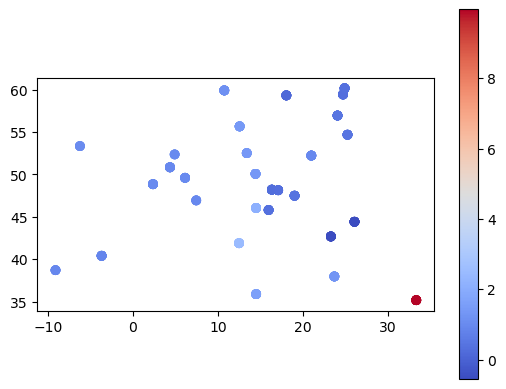

In [30]:
# Visualize results
gdf['GWR_intercept'] = results.params[:, 0]
gdf['GWR_slope'] = results.params[:, 1]

# Plot the map
gdf.plot(column='GWR_slope', cmap='coolwarm', legend=True)

In [31]:
# Load Europe shapefile from an online resource
world = gpd.read_file('world.gpkg')

In [32]:
#world.to_file('world.gpkg', driver='GPKG')
#world.to_file('world.shp', driver='ESRI Shapefile')
world.to_file('world.geojson', driver='GeoJSON')

In [33]:
print(isinstance(world.geometry, str))
print(isinstance(world.geometry, pd.Series))
print(isinstance(world.geometry, gpd.GeoSeries))
print(world.crs)

False
True
True
EPSG:4326


<Axes: >

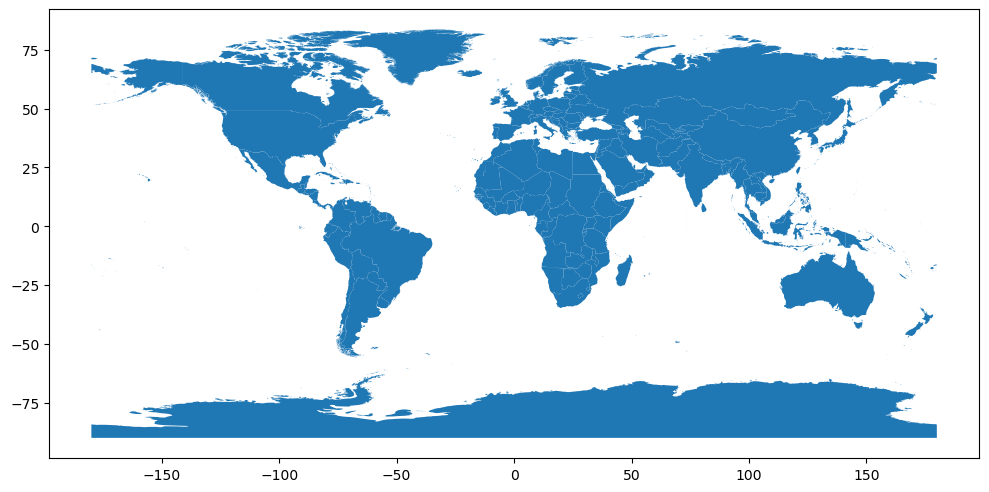

In [34]:
world2 = world.to_crs('epsg:4326')
world2.plot(figsize=(12,8))

In [35]:
# Filter Europe countries from the world shapefile
europe_countries = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 
    'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 
    'MLT', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 
    'SWE', 'CHE'
]
europe = world2[world2['ISO3'].isin(europe_countries)]

In [36]:
print(europe.columns)

Index(['FIPS', 'ISO2', 'ISO3', 'UN', 'NAME', 'AREA', 'POP2005', 'REGION', 'SUBREGION', 'LON', 'LAT', 'geometry'], dtype='object')


In [37]:
# Function to plot a map
def plot_map(column, title, cmap='Blues'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    europe.boundary.plot(ax=ax, color='black', linewidth=0.8)
    norm = Normalize(vmin=europe[column].min(), vmax=europe[column].max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    europe.plot(column=column, cmap=cmap, legend=False, ax=ax, edgecolor='black', linewidth=0.5, norm=norm)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(column, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xlim([-25, 45])
    ax.set_ylim([34, 72])
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    return fig

In [38]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index', 'geometry', 'GWR_intercept', 'GWR_slope'], dtype='object')


In [39]:
# Ensure the Europe shapefile has the correct CRS
europe.set_crs(epsg=4326, allow_override=True)

# Merge GWR results with Europe shapefile based on ISO3 codes
gdf = gdf.set_index('ISO3')
europe = europe.set_index('ISO3')



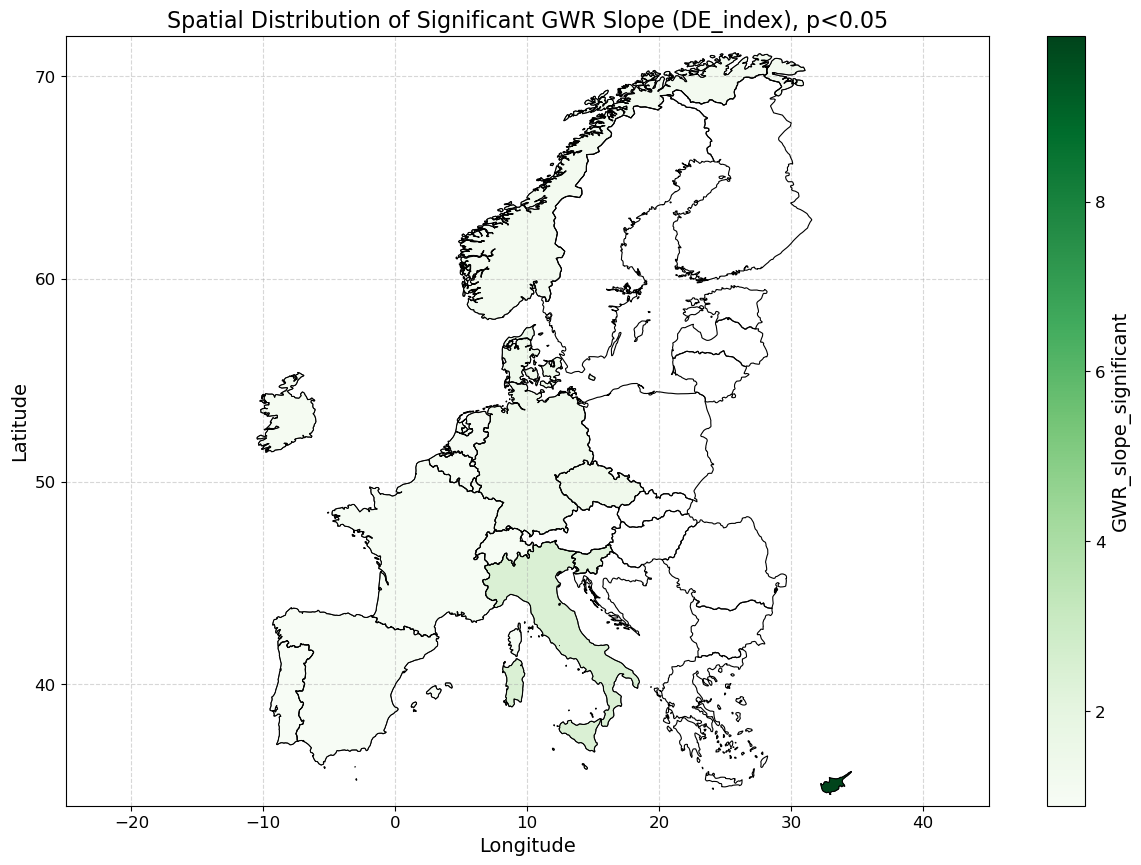

In [40]:
# Step 1: Calculate local t-values
gdf['t_value'] = results.params[:, 1] / results.bse[:, 1]

# Step 2: Calculate local p-values

local_df = results.n - results.tr_S
gdf['p_value'] = 2 * (1 - stats.t.cdf(np.abs(gdf['t_value']), df=local_df))

# Step 3: Filter out regions where the slope is not significant at the 0.05 level
# Only keep regions where p_value < 0.05
significant_gdf = gdf[gdf['p_value'] < 0.05]

# Optional: Calculate the average slope for significant regions
average_slope_significant = significant_gdf.groupby('ISO3')['GWR_slope'].mean()
europe['GWR_slope_significant'] = average_slope_significant

# Step 4: Plot only the significant regions
# Assuming 'plot_map' is your custom function for plotting
fig = plot_map('GWR_slope_significant', 'Spatial Distribution of Significant GWR Slope (DE_index), p<0.05', cmap='Greens')
fig.savefig('GWR1.png', dpi=300, bbox_inches='tight')

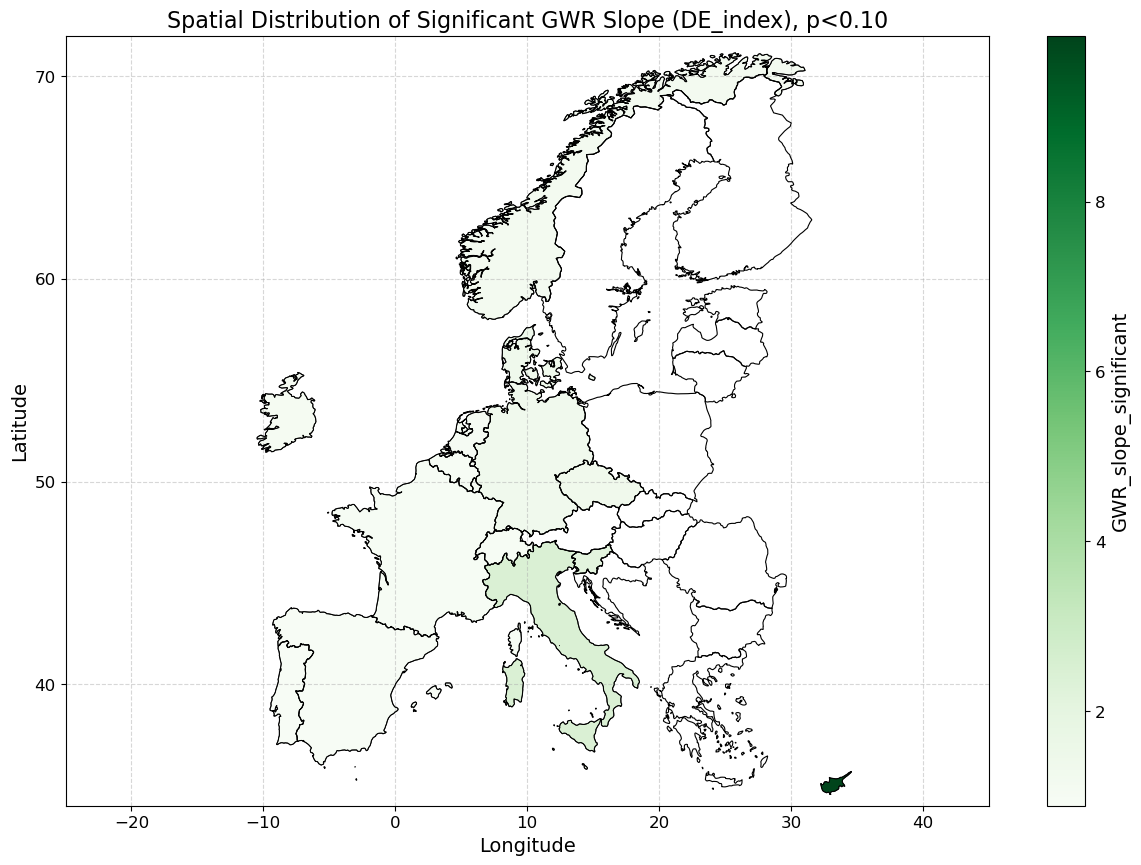

In [41]:
# Step 3: Filter out regions where the slope is not significant at the 0.05 level
# Only keep regions where p_value < 0.05
significant_gdf = gdf[gdf['p_value'] < 0.10]

# Optional: Calculate the average slope for significant regions
average_slope_significant = significant_gdf.groupby('ISO3')['GWR_slope'].mean()
europe['GWR_slope_significant'] = average_slope_significant

# Step 4: Plot only the significant regions
# Assuming 'plot_map' is your custom function for plotting
fig = plot_map('GWR_slope_significant', 'Spatial Distribution of Significant GWR Slope (DE_index), p<0.10', cmap='Greens')
fig.savefig('GWR2.png', dpi=300, bbox_inches='tight')

In [42]:
print(gdf.columns)

Index(['country', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index', 'geometry', 'GWR_intercept', 'GWR_slope', 't_value', 'p_value'], dtype='object')


In [43]:
# Ensure all required columns are present
required_columns = ['latitude', 'longitude', 'DE_index', 'Innovation_index', 'ISO3']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"None of {missing_columns} are in the columns")

# Create GeoDataFrame for the input data, ensuring all columns are kept
gdf = gpd.GeoDataFrame(data.copy(), geometry=gpd.points_from_xy(data.longitude, data.latitude))

# Check the columns and head of the GeoDataFrame
print("GeoDataFrame columns:", gdf.columns)
print(gdf.head())

# Ensure the ISO3 column exists in gdf
if 'ISO3' not in gdf.columns:
    raise KeyError("ISO3 column is missing in the GeoDataFrame")

GeoDataFrame columns: Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index', 'geometry'], dtype='object')
   country ISO3  year  broadband  telephone  cellular  internet  credit  education   ict  tech  patent_residents  patent_nonresidents  researchers    RD     gdppc  urban  articles  business  fdi_outflow  fdi_inflow       gdp  gdp_growth  Innovation_index  latitude  longitude  gdp_log  patent  DE_index                   geometry
0  Austria  AUT  2009       0.05       0.06      0.10      0.60    0.32      67.99  0.08  0.19            2263.0                  292      4158.86  2.60  42655.19  57.68  10837.18      1.10         3.87        3.56  3.56e+11       -3.76              0.08     48.2

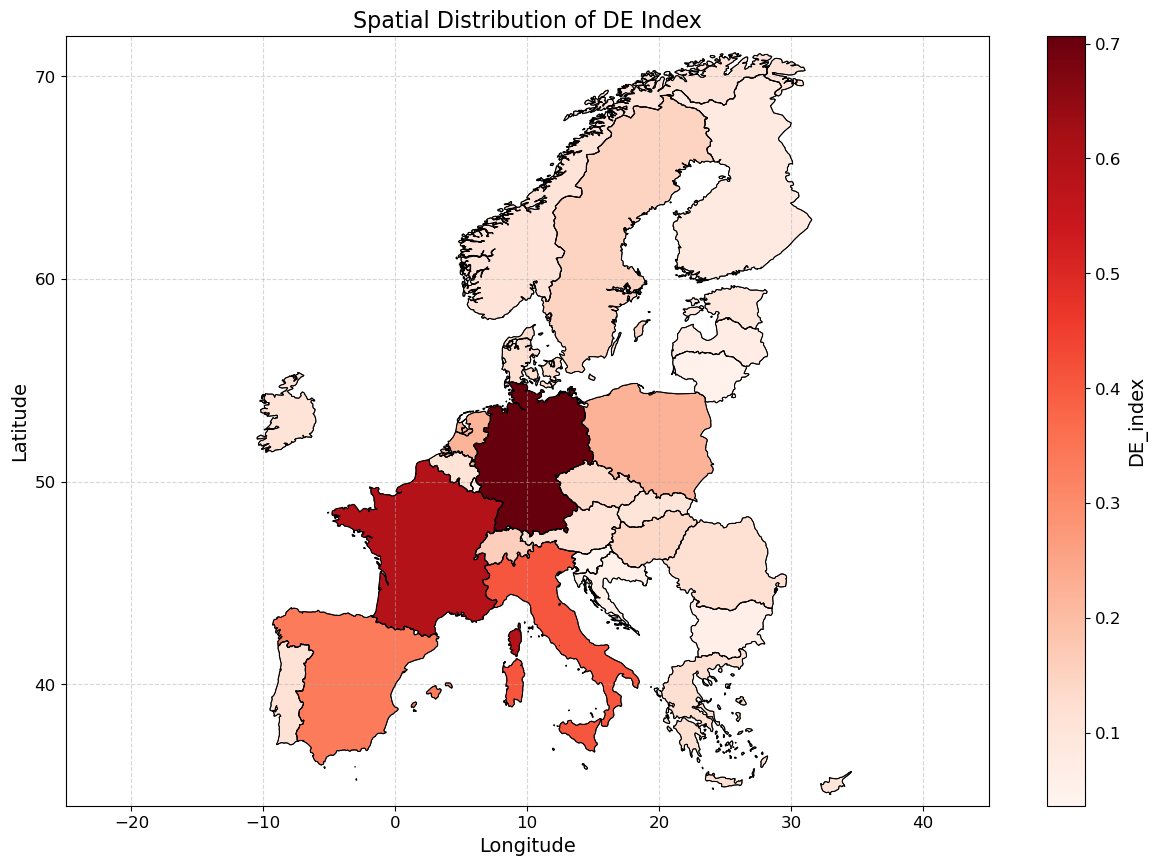

In [44]:
# Calculate the average DE_index for each country
average_de_index = gdf.groupby('ISO3')['DE_index'].mean()
europe['DE_index'] = average_de_index

# Plot DE_index using a detailed color scale

fig = plot_map('DE_index', 'Spatial Distribution of DE Index', cmap='Reds')
fig.savefig('DE.png', dpi=300, bbox_inches='tight')

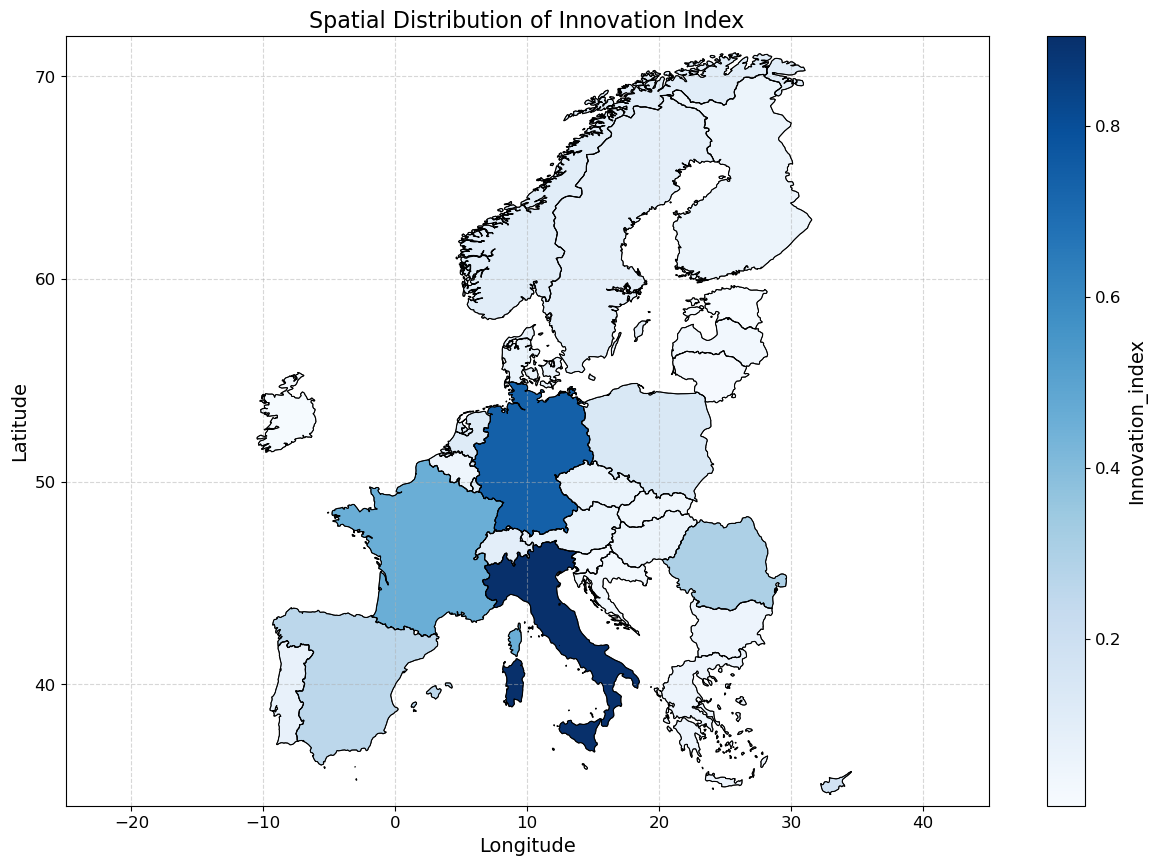

In [45]:
# Calculate the average Innovation_index for each country
average_innovation = gdf.groupby('ISO3')['Innovation_index'].mean()
europe['Innovation_index'] = average_innovation

# Plot Innovation_index
fig = plot_map('Innovation_index', 'Spatial Distribution of Innovation Index', cmap='Blues')
fig.savefig('Innovation.png', dpi=300, bbox_inches='tight')

# 5.Spatial Autocorrelation

## 5.1 Weight matrix

### Geographical Distance Matrix

In [46]:
# Extract the country names and coordinates
countries = data['country']
coordinates = data[['latitude', 'longitude']].values

In [47]:
# Calculate the geographical distance matrix
num_countries = len(countries)
distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            distances[i, j] = geodesic(coordinates[i], coordinates[j]).kilometers
        else:
            distances[i, j] = 0  # Distance to itself is 0

In [48]:
# Add a small value to non-diagonal zero elements to avoid infinite weights
epsilon = 1e-5
distances[distances == 0] = epsilon

# Print the geographical distance matrix
print("Geographical Distance Matrix:")
print(distances)

Geographical Distance Matrix:
[[1.0000000e-05 1.0000000e-05 1.0000000e-05 ... 6.8485234e+02
  6.8485234e+02 6.8485234e+02]
 [1.0000000e-05 1.0000000e-05 1.0000000e-05 ... 6.8485234e+02
  6.8485234e+02 6.8485234e+02]
 [1.0000000e-05 1.0000000e-05 1.0000000e-05 ... 6.8485234e+02
  6.8485234e+02 6.8485234e+02]
 ...
 [6.8485234e+02 6.8485234e+02 6.8485234e+02 ... 1.0000000e-05
  1.0000000e-05 1.0000000e-05]
 [6.8485234e+02 6.8485234e+02 6.8485234e+02 ... 1.0000000e-05
  1.0000000e-05 1.0000000e-05]
 [6.8485234e+02 6.8485234e+02 6.8485234e+02 ... 1.0000000e-05
  1.0000000e-05 1.0000000e-05]]


In [49]:
# Construct the geographical distance weight matrix (inverse square of distances)
W1 = np.zeros_like(distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W1 = 1 / (distances ** 2)
    W1[distances == 0] = 0  # Set diagonal to 0 to avoid division by zero


In [50]:
# Print the geographical distance weight matrix
print("Geographical Distance Weight Matrix:")
print(W1)

Geographical Distance Weight Matrix:
[[1.00000000e+10 1.00000000e+10 1.00000000e+10 ... 2.13209284e-06
  2.13209284e-06 2.13209284e-06]
 [1.00000000e+10 1.00000000e+10 1.00000000e+10 ... 2.13209284e-06
  2.13209284e-06 2.13209284e-06]
 [1.00000000e+10 1.00000000e+10 1.00000000e+10 ... 2.13209284e-06
  2.13209284e-06 2.13209284e-06]
 ...
 [2.13209284e-06 2.13209284e-06 2.13209284e-06 ... 1.00000000e+10
  1.00000000e+10 1.00000000e+10]
 [2.13209284e-06 2.13209284e-06 2.13209284e-06 ... 1.00000000e+10
  1.00000000e+10 1.00000000e+10]
 [2.13209284e-06 2.13209284e-06 2.13209284e-06 ... 1.00000000e+10
  1.00000000e+10 1.00000000e+10]]


In [51]:
rows, columns = W1.shape
print(f"The matrix has {rows} rows and {columns} columns.")

The matrix has 305 rows and 305 columns.


In [52]:
# Save the weight matrix to a CSV file for later use
#np.savetxt('geographical_distance_weight_matrix.csv', W1, delimiter=',')

In [53]:
#distance_matrix.csv', distances, delimiter=',')

### Economic Distance Matrix

In [54]:
# Extract the country names and GDP per capita
countries = data['country']
gdp_per_capita = data['gdppc'].values

# Calculate the economic distance matrix
num_countries = len(countries)
economic_distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            economic_distances[i, j] = abs(gdp_per_capita[i] - gdp_per_capita[j])
        else:
            economic_distances[i, j] = 0  # Distance to itself is 0

# Print the economic distance matrix
print("Economic Distance Matrix:")
print(economic_distances)

Economic Distance Matrix:
[[    0.        679.31683  1795.80806 ... 40739.17901 41151.25547
  41955.90772]
 [  679.31683     0.       1116.49123 ... 40059.86218 40471.93864
  41276.59089]
 [ 1795.80806  1116.49123     0.      ... 38943.37095 39355.44741
  40160.09966]
 ...
 [40739.17901 40059.86218 38943.37095 ...     0.        412.07646
   1216.72871]
 [41151.25547 40471.93864 39355.44741 ...   412.07646     0.
    804.65225]
 [41955.90772 41276.59089 40160.09966 ...  1216.72871   804.65225
      0.     ]]


In [55]:
# Construct the economic distance weight matrix (inverse of economic distances)
W2 = np.zeros_like(economic_distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W2 = 1 / economic_distances
    W2[economic_distances == 0] = 0  # Set diagonal to 0 to avoid division by zero

# Print the economic distance weight matrix
print("Economic Distance Weight Matrix:")
print(W2)

Economic Distance Weight Matrix:
[[0.00000000e+00 1.47206716e-03 5.56852384e-04 ... 2.45463955e-05
  2.43005952e-05 2.38345457e-05]
 [1.47206716e-03 0.00000000e+00 8.95663103e-04 ... 2.49626420e-05
  2.47084779e-05 2.42268070e-05]
 [5.56852384e-04 8.95663103e-04 0.00000000e+00 ... 2.56783112e-05
  2.54094431e-05 2.49003366e-05]
 ...
 [2.45463955e-05 2.49626420e-05 2.56783112e-05 ... 0.00000000e+00
  2.42673411e-03 8.21875897e-04]
 [2.43005952e-05 2.47084779e-05 2.54094431e-05 ... 2.42673411e-03
  0.00000000e+00 1.24277289e-03]
 [2.38345457e-05 2.42268070e-05 2.49003366e-05 ... 8.21875897e-04
  1.24277289e-03 0.00000000e+00]]


### Economic-Geographical Matrix

In [56]:
W3 = W1 * W2

In [57]:
# Calculate Moran's I using the economic-geographical weight matrix
# Convert the economic-geographical weight matrix to a pysal weights object
w1 = full2W(W1)
w2 = full2W(W2)
w3 = full2W(W3)

moran_DE = Moran(data['DE_index'], w3)

print(f"DE Moran's I: {moran_DE.I}")
print(f"P-value: {moran_DE.p_sim}")

DE Moran's I: 0.9902822578882003
P-value: 0.001


In [58]:
moran_innovation = Moran(data['Innovation_index'], w3)

print(f"Innovation Moran's I: {moran_innovation.I}")
print(f"P-value: {moran_innovation.p_sim}")

Innovation Moran's I: 0.8171700753894771
P-value: 0.001


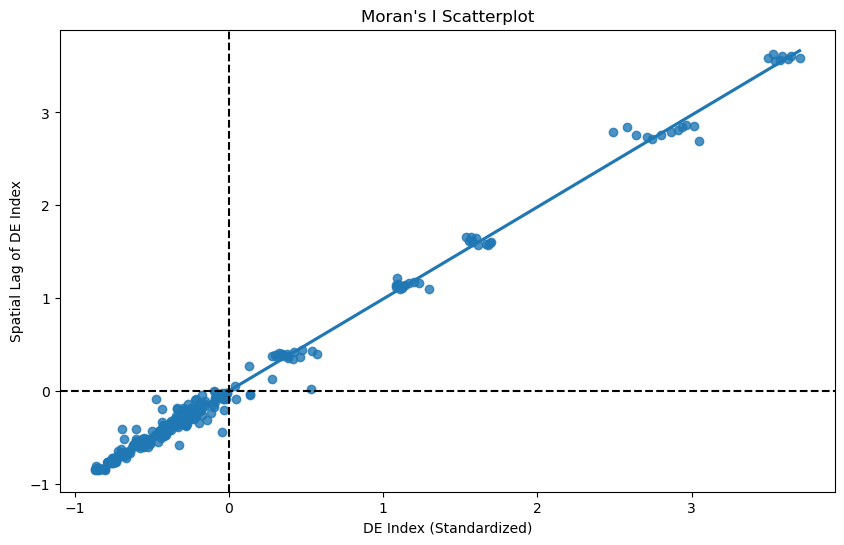

In [59]:
# Manually create the Moran scatter plot
z = (data['DE_index'] - data['DE_index'].mean()) / data['DE_index'].std()
wz = w3.sparse @ z

plt.figure(figsize=(10, 6))
sns.regplot(x=z, y=wz, ci=None)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')
plt.title("Moran's I Scatterplot")
plt.xlabel("DE Index (Standardized)")
plt.ylabel("Spatial Lag of DE Index")
plt.savefig('Moran.png', dpi=300, bbox_inches='tight')
plt.show()


# 6.Spatial Lag Model (SLM)

## 6.1.Static Spatial Panel Model

In [60]:
from spreg import OLS, ML_Lag, ML_Error, LMtests

In [61]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index', 'geometry'], dtype='object')


In [62]:
gdf.set_index(['country', 'year'], inplace=True, drop=False)

In [63]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index', 'geometry'], dtype='object')


In [64]:
# Define the dependent variable (y) and independent variables (X)
#y = gdf['Innovation_index']
#X = gdf[['DE_index', 'gdppc', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth','gdp']]

# Add a constant term
X = sm.add_constant(X)

In [65]:
# Prepare the variables for the spatial lag model
y = gdf['Innovation_index'].values
X = gdf[['DE_index', 'urban', 'fdi_inflow', 'gdp_growth', 'fdi_outflow', 'gdp_log']].values

# Add constant term for intercept
X = np.hstack([np.ones((X.shape[0], 1)), X])


# Fit the spatial lag model
model = spreg.ML_Lag(y, X, w=w3, name_y='Innovation_index', name_x=['constant', 'DE_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log'])

print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Innovation_index                Number of Observations:         305
Mean dependent var  :      0.1460                Number of Variables   :           8
S.D. dependent var  :      0.2292                Degrees of Freedom    :         297
Pseudo R-squared    :      0.7697
Spatial Pseudo R-squared:  0.6084
Sigma-square ML     :       0.012                Log likelihood        :     224.757
S.E of regression   :       0.110                Akaike info criterion :    -433.514
                                                 Schwarz criterion     :    -403.752

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------

In [66]:
# Determine the index position of DE_index in X
variable_index = 0  #DE_index is the first independent variable

# Monte Carlo simulation to calculate direct and indirect effects
n_simulations = 1000  # Number of simulations
direct_effects = []
indirect_effects = []
w= w3

for _ in range(n_simulations):
    # Perturb model coefficients
    perturbed_betas = np.random.multivariate_normal(model.betas.flatten(), model.vm, size=1).flatten()
    
    # model.rho is a scalar, so use it directly
    perturbed_rho = np.random.normal(model.rho, np.sqrt(model.vm[-1, -1]), size=1)
    
    S = np.linalg.inv(np.eye(w.n) - perturbed_rho * w.full()[0])
    
    # Calculate the effect for DE_index
    direct_effect = np.mean(np.diag(S)) * perturbed_betas[variable_index + 1]
    indirect_effect = np.mean(S.sum(axis=1) - np.diag(S)) * perturbed_betas[variable_index + 1]
    
    direct_effects.append(direct_effect)
    indirect_effects.append(indirect_effect)

# Calculate standard errors
direct_std_error = np.std(direct_effects)
indirect_std_error = np.std(indirect_effects)

# Calculate mean effects
direct_effect_mean = np.mean(direct_effects)
indirect_effect_mean = np.mean(indirect_effects)

# Calculate t-values
direct_t_value = direct_effect_mean / direct_std_error
indirect_t_value = indirect_effect_mean / indirect_std_error

# Calculate p-values
df = len(y) - X.shape[1] - 1  # Degrees of freedom
direct_p_value = 2 * (1 - t.cdf(np.abs(direct_t_value), df=df))
indirect_p_value = 2 * (1 - t.cdf(np.abs(indirect_t_value), df=df))

# Output results
print("DE_index Direct Effect:", direct_effect_mean)
print("DE_index Direct Effect Standard Error:", direct_std_error)
print("DE_index Direct Effect t-value:", direct_t_value)
print("DE_index Direct Effect p-value:", direct_p_value)

print("DE_index Indirect Effect:", indirect_effect_mean)
print("DE_index Indirect Effect Standard Error:", indirect_std_error)
print("DE_index Indirect Effect t-value:", indirect_t_value)
print("DE_index Indirect Effect p-value:", indirect_p_value)

DE_index Direct Effect: 0.5524256059608007
DE_index Direct Effect Standard Error: 0.09690327130133838
DE_index Direct Effect t-value: 5.700794189320323
DE_index Direct Effect p-value: 2.875968996285394e-08
DE_index Indirect Effect: 0.6053828417830034
DE_index Indirect Effect Standard Error: 0.15752282262253675
DE_index Indirect Effect t-value: 3.8431436899378633
DE_index Indirect Effect p-value: 0.0001485817421897906


In [67]:
constant_columns = np.all(X == X[0, :], axis=0)
print("Constant columns:", constant_columns)


Constant columns: [ True False False False False False False]


In [68]:
#model_sar_gmm = spreg.GM_Lag(y, X, w=w3, name_y='Innovation_index', name_x=['constant','DE_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log'])
#print(model_sar_gmm.summary)

## 6.2 Dynamic Spatial Panel Model

In [69]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index', 'geometry'], dtype='object')


In [70]:
# Prepare the panel data for the dynamic spatial lag model
gdf.set_index(['country', 'year'], inplace=True, drop=False)

# Add lagged variables for all predictors
gdf['L.Innovation_index'] = gdf.groupby(level=0)['Innovation_index'].shift(1)
#gdf['L2.Innovation_index'] = gdf.groupby(level=0)['Innovation_index'].shift(2)
#gdf['L.DE_index'] = gdf.groupby(level=0)['DE_index'].shift(1)

In [71]:
# Drop rows with NaN values created by lagging
gdf.dropna(subset=['L.Innovation_index'], inplace=True)

# Ensure y and X have the correct MultiIndex
y = gdf['Innovation_index']
X = gdf[['DE_index', 'L.Innovation_index']]

In [72]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular', 'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents', 'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban', 'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp', 'gdp_growth', 'Innovation_index', 'latitude', 'longitude', 'gdp_log', 'patent', 'DE_index', 'geometry', 'L.Innovation_index'], dtype='object')


### Re-construct matrix

#### W4

In [73]:
# Extract the country names and coordinates
countries = gdf['country']
coordinates = gdf[['latitude', 'longitude']].values

In [74]:
# Calculate the geographical distance matrix
num_countries = len(countries)
distances = np.zeros((num_countries, num_countries))

In [75]:
for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            distances[i, j] = geodesic(coordinates[i], coordinates[j]).kilometers
        else:
            distances[i, j] = 0  # Distance to itself is 0


In [76]:
# Add a small value to non-diagonal zero elements to avoid infinite weights
epsilon = 1e-5
distances[distances == 0] = epsilon


In [77]:
# Print the geographical distance matrix
print("Geographical Distance Matrix:")
print(distances)


Geographical Distance Matrix:
[[1.0000000e-05 1.0000000e-05 1.0000000e-05 ... 6.8485234e+02
  6.8485234e+02 6.8485234e+02]
 [1.0000000e-05 1.0000000e-05 1.0000000e-05 ... 6.8485234e+02
  6.8485234e+02 6.8485234e+02]
 [1.0000000e-05 1.0000000e-05 1.0000000e-05 ... 6.8485234e+02
  6.8485234e+02 6.8485234e+02]
 ...
 [6.8485234e+02 6.8485234e+02 6.8485234e+02 ... 1.0000000e-05
  1.0000000e-05 1.0000000e-05]
 [6.8485234e+02 6.8485234e+02 6.8485234e+02 ... 1.0000000e-05
  1.0000000e-05 1.0000000e-05]
 [6.8485234e+02 6.8485234e+02 6.8485234e+02 ... 1.0000000e-05
  1.0000000e-05 1.0000000e-05]]


In [78]:
rows, columns = distances.shape
print(f"The matrix has {rows} rows and {columns} columns.")

The matrix has 276 rows and 276 columns.


In [79]:
# Construct the geographical distance weight matrix (inverse square of distances)
W4 = np.zeros_like(distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W4 = 1 / (distances ** 2)
    W4[distances == 0] = 0  # Set diagonal to 0 to avoid division by zero

In [80]:
# Print the geographical distance weight matrix
print("Geographical Distance Weight Matrix:")
print(W4)

Geographical Distance Weight Matrix:
[[1.00000000e+10 1.00000000e+10 1.00000000e+10 ... 2.13209284e-06
  2.13209284e-06 2.13209284e-06]
 [1.00000000e+10 1.00000000e+10 1.00000000e+10 ... 2.13209284e-06
  2.13209284e-06 2.13209284e-06]
 [1.00000000e+10 1.00000000e+10 1.00000000e+10 ... 2.13209284e-06
  2.13209284e-06 2.13209284e-06]
 ...
 [2.13209284e-06 2.13209284e-06 2.13209284e-06 ... 1.00000000e+10
  1.00000000e+10 1.00000000e+10]
 [2.13209284e-06 2.13209284e-06 2.13209284e-06 ... 1.00000000e+10
  1.00000000e+10 1.00000000e+10]
 [2.13209284e-06 2.13209284e-06 2.13209284e-06 ... 1.00000000e+10
  1.00000000e+10 1.00000000e+10]]


In [81]:
rows, columns = W4.shape
print(f"The matrix has {rows} rows and {columns} columns.")

The matrix has 276 rows and 276 columns.


#### W5

In [82]:
# Extract the country names and GDP per capita
countries = gdf['country']
gdp_per_capita = gdf['gdppc'].values

# Calculate the economic distance matrix
num_countries = len(countries)
economic_distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            economic_distances[i, j] = abs(gdp_per_capita[i] - gdp_per_capita[j])
        else:
            economic_distances[i, j] = 0  # Distance to itself is 0

# Print the economic distance matrix
print("Economic Distance Matrix:")
print(economic_distances)

Economic Distance Matrix:
[[    0.       1116.49123  1215.37274 ... 40059.86218 40471.93864
  41276.59089]
 [ 1116.49123     0.         98.88151 ... 38943.37095 39355.44741
  40160.09966]
 [ 1215.37274    98.88151     0.      ... 38844.48944 39256.5659
  40061.21815]
 ...
 [40059.86218 38943.37095 38844.48944 ...     0.        412.07646
   1216.72871]
 [40471.93864 39355.44741 39256.5659  ...   412.07646     0.
    804.65225]
 [41276.59089 40160.09966 40061.21815 ...  1216.72871   804.65225
      0.     ]]


In [83]:
# Construct the economic distance weight matrix (inverse of economic distances)
W5 = np.zeros_like(economic_distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W5 = 1 / economic_distances
    W5[economic_distances == 0] = 0  # Set diagonal to 0 to avoid division by zero

In [84]:
# Print the economic distance weight matrix
print("Economic Distance Weight Matrix:")
print(W5)

Economic Distance Weight Matrix:
[[0.00000000e+00 8.95663103e-04 8.22792850e-04 ... 2.49626420e-05
  2.47084779e-05 2.42268070e-05]
 [8.95663103e-04 0.00000000e+00 1.01131142e-02 ... 2.56783112e-05
  2.54094431e-05 2.49003366e-05]
 [8.22792850e-04 1.01131142e-02 0.00000000e+00 ... 2.57436773e-05
  2.54734457e-05 2.49617971e-05]
 ...
 [2.49626420e-05 2.56783112e-05 2.57436773e-05 ... 0.00000000e+00
  2.42673411e-03 8.21875897e-04]
 [2.47084779e-05 2.54094431e-05 2.54734457e-05 ... 2.42673411e-03
  0.00000000e+00 1.24277289e-03]
 [2.42268070e-05 2.49003366e-05 2.49617971e-05 ... 8.21875897e-04
  1.24277289e-03 0.00000000e+00]]


In [85]:
rows, columns = W5.shape
print(f"The matrix has {rows} rows and {columns} columns.")

The matrix has 276 rows and 276 columns.


#### W6

In [86]:
W6 = W4*W5
print(W6)

[[0.00000000e+00 8.95663103e+06 8.22792850e+06 ... 5.32226704e-11
  5.26807688e-11 5.16538017e-11]
 [8.95663103e+06 0.00000000e+00 1.01131142e+08 ... 5.47485436e-11
  5.41752917e-11 5.30898294e-11]
 [8.22792850e+06 1.01131142e+08 0.00000000e+00 ... 5.48879100e-11
  5.43117512e-11 5.32208690e-11]
 ...
 [5.32226704e-11 5.47485436e-11 5.48879100e-11 ... 0.00000000e+00
  2.42673411e+07 8.21875897e+06]
 [5.26807688e-11 5.41752917e-11 5.43117512e-11 ... 2.42673411e+07
  0.00000000e+00 1.24277289e+07]
 [5.16538017e-11 5.30898294e-11 5.32208690e-11 ... 8.21875897e+06
  1.24277289e+07 0.00000000e+00]]


In [87]:
rows, columns = W6.shape
print(f"The matrix has {rows} rows and {columns} columns.")

The matrix has 276 rows and 276 columns.


In [88]:
w4 = full2W(W4)
w5 = full2W(W5)
w6 = full2W(W6)

### Generalized method of moments(GMM)

In [89]:
print(y.shape)
print(X.shape)

(276,)
(276, 2)


In [90]:
matching_index = gdf.index

In [91]:
y = gdf['Innovation_index'].values  # Dependent variable
X = gdf[['DE_index', 'L.Innovation_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log']].values  # Independent variables

In [92]:
w6.transform = 'r'

In [103]:
model_sar_gmm = spreg.GM_Lag(y, X, w=w6, name_y='Innovation_index', name_x=['L.Innovation_index', 'DE_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log'])
print(model_sar_gmm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Innovation_index                Number of Observations:         276
Mean dependent var  :      0.1452                Number of Variables   :           9
S.D. dependent var  :      0.2267                Degrees of Freedom    :         267
Pseudo R-squared    :      0.8619
Spatial Pseudo R-squared:  0.8642

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.0181550       0.1423656       0.1275237       0.8985259
  L.Innovation_index       0.0920516       0.0680931       1.3518504       0.1764232
            DE_index       0.6921676       0.0546707   

In [94]:
# Calculating growth rate
gdf['growth_rate'] = np.log(gdf['Innovation_index']) - np.log(gdf['L.Innovation_index'])

Absolute Convergence Model

In [95]:
# Setting up the panel data model
#gdf.set_index(['country', 'year'], inplace=True)

# Absolute convergence model
X_abs = np.log(gdf['L.Innovation_index'])
X_abs = sm.add_constant(X_abs)

# Running Fixed Effects Model
model_abs = PanelOLS(gdf['growth_rate'], X_abs, entity_effects=True)
results_abs = model_abs.fit()

print(results_abs.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            growth_rate   R-squared:                        0.1250
Estimator:                   PanelOLS   R-squared (Between):             -17.175
No. Observations:                 276   R-squared (Within):               0.1250
Date:                Tue, Aug 27 2024   R-squared (Overall):             -0.7518
Time:                        15:32:41   Log-likelihood                   -136.21
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      35.142
Entities:                          29   P-value                           0.0000
Avg Obs:                       9.5172   Distribution:                   F(1,246)
Min Obs:                       3.0000                                           
Max Obs:                       11.000   F-statistic (robust):             35.142
                            

In [96]:
X_cond = np.log(gdf['L.Innovation_index'])

X_cond = pd.concat([X_cond, gdf[['DE_index']]], axis=1)

# Add a constant term
X_cond = sm.add_constant(X_cond)

# Run the Fixed Effects Model with entity effects (Conditional Convergence)
model_cond = PanelOLS(gdf['growth_rate'], X_cond, entity_effects=True)
results_cond = model_cond.fit()

# Print the summary of the model results
print(results_cond.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            growth_rate   R-squared:                        0.1864
Estimator:                   PanelOLS   R-squared (Between):             -146.04
No. Observations:                 276   R-squared (Within):               0.1864
Date:                Tue, Aug 27 2024   R-squared (Overall):             -6.3476
Time:                        15:32:41   Log-likelihood                   -126.17
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      28.059
Entities:                          29   P-value                           0.0000
Avg Obs:                       9.5172   Distribution:                   F(2,245)
Min Obs:                       3.0000                                           
Max Obs:                       11.000   F-statistic (robust):             28.059
                            

In [97]:
X_cond = np.log(gdf['L.Innovation_index'])

X_cond = pd.concat([X_cond, gdf[['DE_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log']]], axis=1)

# Add a constant term
X_cond = sm.add_constant(X_cond)

# Run the Fixed Effects Model with entity effects (Conditional Convergence)
model_cond = PanelOLS(gdf['growth_rate'], X_cond, entity_effects=True)
results_cond = model_cond.fit()

# Print the summary of the model results
print(results_cond.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:            growth_rate   R-squared:                        0.2370
Estimator:                   PanelOLS   R-squared (Between):             -208.44
No. Observations:                 276   R-squared (Within):               0.2370
Date:                Tue, Aug 27 2024   R-squared (Overall):             -9.1160
Time:                        15:32:41   Log-likelihood                   -117.30
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.650
Entities:                          29   P-value                           0.0000
Avg Obs:                       9.5172   Distribution:                   F(7,240)
Min Obs:                       3.0000                                           
Max Obs:                       11.000   F-statistic (robust):             10.650
                            

In [98]:
# Granger causality test to check if X Granger-causes Y and vice versa
grangercausalitytests(gdf[['Innovation_index', 'DE_index']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1597  , p=0.0137  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=6.2277  , p=0.0126  , df=1
likelihood ratio test: chi2=6.1582  , p=0.0131  , df=1
parameter F test:         F=6.1597  , p=0.0137  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3415  , p=0.0369  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=6.8073  , p=0.0333  , df=2
likelihood ratio test: chi2=6.7241  , p=0.0347  , df=2
parameter F test:         F=3.3415  , p=0.0369  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2204  , p=0.0861  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=6.8365  , p=0.0773  , df=3
likelihood ratio test: chi2=6.7523  , p=0.0802  , df=3
parameter F test:         F=2.2204  , p=0.0861  , df_denom=266, df_num=3


{1: ({'ssr_ftest': (6.159737856861087, 0.013673154828892932, 272.0, 1),
   'ssr_chi2test': (6.227676142047056, 0.012576868219490006, 1),
   'lrtest': (6.1582067207737055, 0.013080375443257722, 1),
   'params_ftest': (6.1597378568609376, 0.01367315482889436, 272.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.341528419916894, 0.03685755139088513, 269.0, 2),
   'ssr_chi2test': (6.807277227191293, 0.033252058181662165, 2),
   'lrtest': (6.724091925251969, 0.03466426455383394, 2),
   'params_ftest': (3.3415284199168975, 0.03685755139088513, 269.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.2204056211424454, 0.08612297889314142, 266.0, 3),
   'ssr_chi2test': (6.836512044043846, 0.07729533109676165, 3),
   'lrtest': (6.75231426863138, 0.08022568803551866, 3),
   'params_ftest': (2.220405621142448, 0.08612297889314142, 266.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0

In [99]:
grangercausalitytests(gdf[['DE_index', 'Innovation_index']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9981  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9981  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9981  , df=1
parameter F test:         F=0.0000  , p=0.9981  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5543  , p=0.5751  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=1.1292  , p=0.5686  , df=2
likelihood ratio test: chi2=1.1268  , p=0.5693  , df=2
parameter F test:         F=0.5543  , p=0.5751  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3888  , p=0.7612  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=1.1970  , p=0.7537  , df=3
likelihood ratio test: chi2=1.1944  , p=0.7544  , df=3
parameter F test:         F=0.3888  , p=0.7612  , df_denom=266, df_num=3


{1: ({'ssr_ftest': (5.469136729107377e-06, 0.998135768301249, 272.0, 1),
   'ssr_chi2test': (5.529458090090179e-06, 0.9981237921590503, 1),
   'lrtest': (5.5294578942266526e-06, 0.9981237921922796, 1),
   'params_ftest': (5.469136708289976e-06, 0.9981357683115424, 272.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5542791053015753, 0.5751409534394378, 269.0, 2),
   'ssr_chi2test': (1.1291633818039528, 0.5685979467113577, 2),
   'lrtest': (1.1268430937977882, 0.5692579850051033, 2),
   'params_ftest': (0.5542791053015776, 0.5751409534394378, 269.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.3887715271973304, 0.7611823320310097, 266.0, 3),
   'ssr_chi2test': (1.197007070581254, 0.7537222289408253, 3),
   'lrtest': (1.194390492986713, 0.7543500152545716, 3),
   'params_ftest': (0.3887715271973291, 0.761182332031024, 266.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.,

In [100]:
for var in ['DE_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log']:  
    print(f"Testing Granger causality between {var} and Y")
    grangercausalitytests(gdf[['Innovation_index', var]], maxlag=3)

Testing Granger causality between DE_index and Y

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1597  , p=0.0137  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=6.2277  , p=0.0126  , df=1
likelihood ratio test: chi2=6.1582  , p=0.0131  , df=1
parameter F test:         F=6.1597  , p=0.0137  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3415  , p=0.0369  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=6.8073  , p=0.0333  , df=2
likelihood ratio test: chi2=6.7241  , p=0.0347  , df=2
parameter F test:         F=3.3415  , p=0.0369  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2204  , p=0.0861  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=6.8365  , p=0.0773  , df=3
likelihood ratio test: chi2=6.7523  , p=0.0802  , df=3
parameter F test:         F=2.2204  , p=0.0861  , df_denom=266, df_num=3
Testing Granger causality between urban and Y

In [101]:
for var in ['DE_index', 'urban', 'fdi_inflow', 'fdi_outflow', 'gdp_growth', 'gdp_log']:  
    print(f"Testing Granger causality between {var} and Y")
    grangercausalitytests(gdf[[var, 'Innovation_index']], maxlag=3)

Testing Granger causality between DE_index and Y

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9981  , df_denom=272, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9981  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9981  , df=1
parameter F test:         F=0.0000  , p=0.9981  , df_denom=272, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5543  , p=0.5751  , df_denom=269, df_num=2
ssr based chi2 test:   chi2=1.1292  , p=0.5686  , df=2
likelihood ratio test: chi2=1.1268  , p=0.5693  , df=2
parameter F test:         F=0.5543  , p=0.5751  , df_denom=269, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3888  , p=0.7612  , df_denom=266, df_num=3
ssr based chi2 test:   chi2=1.1970  , p=0.7537  , df=3
likelihood ratio test: chi2=1.1944  , p=0.7544  , df=3
parameter F test:         F=0.3888  , p=0.7612  , df_denom=266, df_num=3
Testing Granger causality between urban and Y